# Train ordinary torch model 

If you have ready to use ordinary torch model it can be integrated into pipeline for training and inference.

In [1]:
import sys
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
from torchvision.models import resnet50

sys.path.append("../..")

from batchflow import Pipeline, B, C, D, V
from batchflow.models.torch import TorchModel
from batchflow.opensets import Imagenette160

In [2]:
BATCH_SIZE = 64

# Create dataset

Load [Imagenette](https://github.com/fastai/imagenette) dataset. It may take few minutes.

In [3]:
dataset = Imagenette160()

# Define pipeline config

We use `resnet50` model from `torchvision.models` zoo.   
In the config you must specify that the `body` of your model is `resnet50` module. Optionally you could add more laysers on top of the net spcidying `head`.

In [4]:
config = {'inputs/images/shape': B.image_shape,
          'inputs/labels/classes': D.num_classes,
          'initial_block/inputs': 'images',
          'body': resnet50(),
          'loss': 'ce',
          'output/predicted': ['proba', 'labels']
}

# Create train pipeline

In the pipeline we apply two preprocessing steps to the batch of images.   
First, we crop the images so the whole batch consists of the crops with the same size.   
Secondly, convert the batch of PIL images to the numpy array to make it compatible with torch models.

In [5]:
train_pipeline = (dataset.train.p
                    .crop(shape=(160, 160), origin='center')
                    .to_array(channels='first', dtype='float32') 
                    .train_model('my_model', B.images, B.labels, fetches='loss',
                                 save_to=V('loss_history', mode='a'))
                 )

In [6]:
(train_pipeline.before
                .init_variable('loss_history', default=[])
                .init_model('dynamic', TorchModel, 'my_model', config)
)

Training may take some time.

# Train the model

In [8]:
train_pipeline.run(BATCH_SIZE, shuffle=True, n_iters=500, drop_last=True, bar=True)

100%|██████████| 500/500 [40:53<00:00,  4.92s/it]


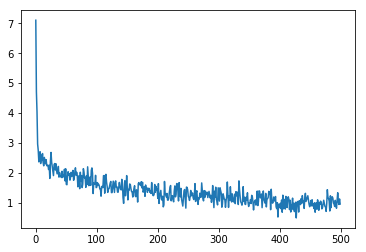

In [9]:
plt.plot(train_pipeline.v('loss_history'))

# Test the model 

In [10]:
test_pipeline = (dataset.test.p
                    .import_model('my_model', train_pipeline)
                    .crop(shape=(160,160), origin='center')
                    .to_array(channels='first', dtype='float32')
                    .predict_model('my_model', B.images,
                                   fetches=['predicted_proba', 'predicted_labels'],
                                   save_to=[V('pred_proba'), V('pred_labels')])
                    .gather_metrics('class', targets=B.labels, predictions=V('pred_proba'),
                                     fmt='proba', axis=-1, save_to=V('metrics', mode='a'))
                )

In [11]:
(test_pipeline.before
            .init_variable('pred_proba')
            .init_variable('pred_labels')
            .init_variable('metrics', default=None)
)

In [12]:
test_pipeline.run(BATCH_SIZE, shuffle=True, n_epochs=1, drop_last=False, bar=True)

100%|██████████| 8/8 [00:12<00:00,  1.41s/it]


In [13]:
metrics = test_pipeline.get_variable('metrics')

In [14]:
metrics.evaluate('accuracy')

0.5469250801282051

In [15]:
batch = test_pipeline.next_batch(5, shuffle=True)

In [16]:
classes = ['tench', 'English springer', 'cassette player', 'chain saw', 'church', 
           'French horn', 'garbage truck', 'gas pump', 'golf ball', 'parachute']

Take a look at the predictions.

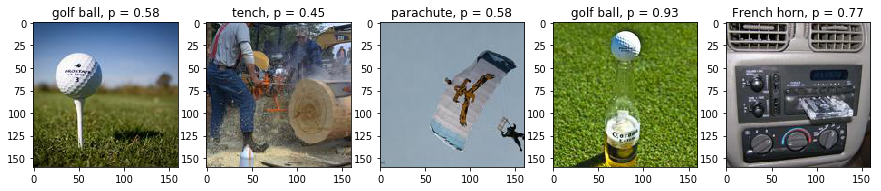

In [17]:
fig, ax = plt.subplots(1, 5, figsize=(15, 5))
for i in range(len(ax)):
    ax[i].imshow(np.transpose(batch.images[i], (1, 2, 0)).astype(int))
    class_pred = batch.pipeline.v('pred_labels')[i]
    class_name = classes[class_pred]
    class_proba = batch.pipeline.v('pred_proba')[i][class_pred]
    ax[i].title.set_text('{0}, p = {1:.2f}'.format(class_name, class_proba))